Please answer the questions below based on the data provided:

- Plot daily sales for all 50 weeks.
- It looks like there has been a sudden change in daily sales. What date did it occur?
- Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?
- Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).
- Assume a given day is divided into four dayparts: 
    - night (12:00AM - 6:00AM), 
    - morning (6:00AM - 12:00PM), 
    - afternoon (12:00PM - 6:00PM)
    - evening (6:00PM - 12:00AM).
    - What is the percentage of sales in each daypart over all 50 weeks?

In [306]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os


# Question 1

### Plot daily sales for all 50 weeks 

In [307]:
path = r"C:\Users\Wen\OneDrive\Documents\Machine Learning\Project\Sales_Data_Analysis\datasets"
file_pattern = os.path.join(path, "sales_week_starting_*.csv")

csv_files  = glob.glob(file_pattern)

data_frames = []

for file in csv_files:
    df = pd.read_csv(file)
    data_frames.append(df)
    
print(len(data_frames))

50


In [308]:
combined_df = pd.concat(data_frames) # combine all dataframes into a single 
print(combined_df)
print(combined_df.dtypes) # since the sale_time is object we need to convert to datatime

sale_day = pd.to_datetime(combined_df['sale_time'])
print(sale_day.dtypes)


                sale_time purchaser_gender
0     2012-10-01 01:42:22           female
1     2012-10-01 02:24:53           female
2     2012-10-01 02:25:40           female
3     2012-10-01 02:30:42           female
4     2012-10-01 02:51:32             male
...                   ...              ...
4994  2013-09-15 23:30:51           female
4995  2013-09-15 23:42:02           female
4996  2013-09-15 23:43:24             male
4997  2013-09-15 23:43:32             male
4998  2013-09-15 23:48:47             male

[204329 rows x 2 columns]
sale_time           object
purchaser_gender    object
dtype: object
datetime64[ns]


In [309]:
daily_sales = sale_day.groupby(sale_day.dt.floor('d')).size().reset_index(name='sales_amount') 
daily_sales.head()


,sale_time,sales_amount
0,2012-10-01,514
1,2012-10-02,482
2,2012-10-03,499
3,2012-10-04,546
4,2012-10-05,476


We plot daily sales for all 50 weeks 

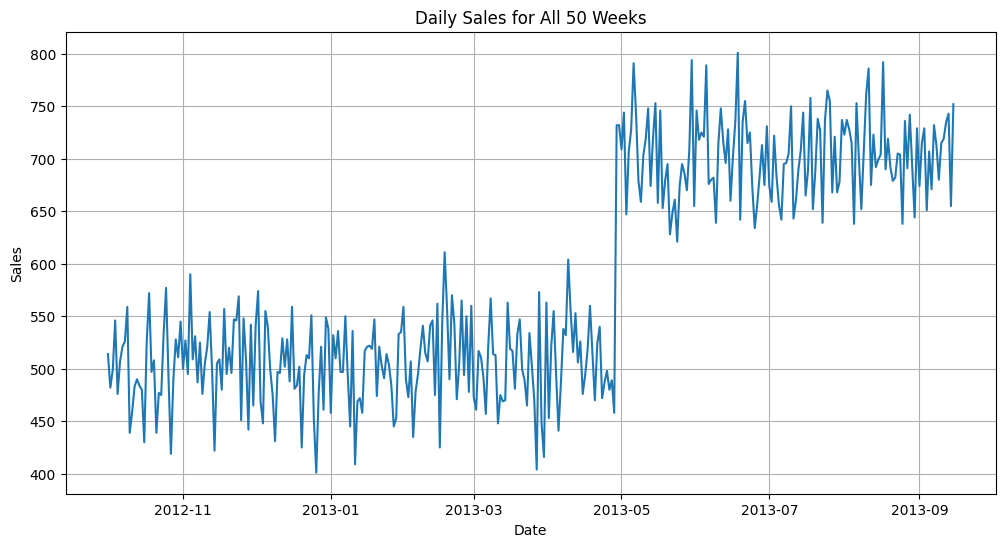

In [310]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['sale_time'], daily_sales['sales_amount'])
plt.title('Daily Sales for All 50 Weeks')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# Question 2 

### It looks like there has been a sudden change in daily sales. What date did it occur?


In [311]:
daily_sales['prev_day_sale_amount'] = daily_sales['sales_amount'].shift(1)
daily_sales['difference_between_prev_day'] = daily_sales['sales_amount'] - daily_sales['prev_day_sale_amount']

print(daily_sales.head())

   sale_time  sales_amount  prev_day_sale_amount  difference_between_prev_day
0 2012-10-01           514                   NaN                          NaN
1 2012-10-02           482                 514.0                        -32.0
2 2012-10-03           499                 482.0                         17.0
3 2012-10-04           546                 499.0                         47.0
4 2012-10-05           476                 546.0                        -70.0


In [312]:
max_difference_row = daily_sales.iloc[daily_sales['difference_between_prev_day'].abs().idxmax()]
print(f"The date with the biggest difference in daily sales is: {max_difference_row['sale_time']} with a difference of {max_difference_row['difference_between_prev_day']} sales.")


The date with the biggest difference in daily sales is: 2013-04-29 00:00:00 with a difference of 274.0 sales.


# Question 3

###  Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?

In [313]:
from scipy import stats

daily_sales.isnull().sum()


sale_time                      0
sales_amount                   0
prev_day_sale_amount           1
difference_between_prev_day    1
dtype: int64

In [314]:
daily_sales.dropna(inplace=True)

t_stat, p_value = stats.ttest_1samp(daily_sales['sales_amount'], max_difference_row['sales_amount'])
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The change in daily sales at the selected date is statistically significant.")
else:
    print("The change in daily sales at the selected date is not statistically significant.")

T-statistic: -26.273266340051002
P-value: 1.3019593251472396e-84
The change in daily sales at the selected date is statistically significant.


The extremely small p-value allows us to reject the null hypothesis, concluding that the change in daily sales on the selected date is statistically significant. 

# Question 4 

### Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).


In [315]:
combined_df['sale_day'] = pd.to_datetime(combined_df['sale_time']).dt.floor('d')
gender_portions_df = combined_df.groupby(['sale_day', 'purchaser_gender']).size().reset_index(name='sales_amount')
print(gender_portions_df)



      sale_day purchaser_gender  sales_amount
0   2012-10-01           female           413
1   2012-10-01             male           101
2   2012-10-02           female           379
3   2012-10-02             male           103
4   2012-10-03           female           386
..         ...              ...           ...
695 2013-09-13             male           537
696 2013-09-14           female           193
697 2013-09-14             male           462
698 2013-09-15           female           230
699 2013-09-15             male           522

[700 rows x 3 columns]


We need to separate the amount for female and male columns

In [316]:
new_df = pd.DataFrame(gender_portions_df['sale_day'].unique(), columns=['sale_day'])

new_df['female_sales_amount'] = pd.Series(gender_portions_df[gender_portions_df['purchaser_gender'] == 'female']['sales_amount'].reset_index(drop=True))
new_df['male_sales_amount'] = pd.Series(gender_portions_df[gender_portions_df['purchaser_gender'] == 'male']['sales_amount'].reset_index(drop=True))
print(new_df)

      sale_day  female_sales_amount  male_sales_amount
0   2012-10-01                  413                101
1   2012-10-02                  379                103
2   2012-10-03                  386                113
3   2012-10-04                  432                114
4   2012-10-05                  368                108
..         ...                  ...                ...
345 2013-09-11                  224                495
346 2013-09-12                  225                510
347 2013-09-13                  206                537
348 2013-09-14                  193                462
349 2013-09-15                  230                522

[350 rows x 3 columns]


Calculate the gender ratio of sales 

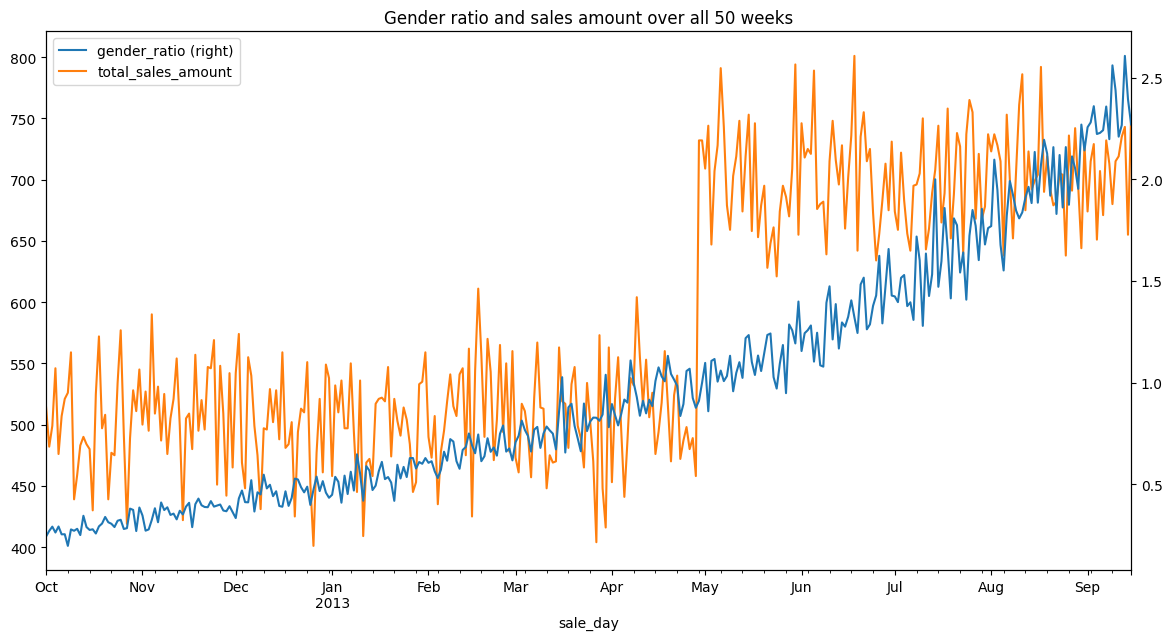

In [317]:
new_df['gender_ratio'] = new_df['male_sales_amount'] / new_df['female_sales_amount']

plot_df = new_df.copy()
plot_df['total_sales_amount'] = plot_df['male_sales_amount'] + plot_df['female_sales_amount']
plot_df.drop(columns=['female_sales_amount', 'male_sales_amount'], inplace=True)
plot_df.index = plot_df['sale_day']
plot_df.drop(columns=['sale_day'], inplace=True)
plot_df.plot(secondary_y = ['gender_ratio'], figsize =(14, 7), title= "Gender ratio and sales amount over all 50 weeks")
plt.show()

The overall increase in sales over the period is not strongly associated with changes in the gender ratio. The pronounced fluctuations in sales are more frequent and variable than the changes in the gender raito. 

Since the gender ratio does not strongly correlate with sales changes, it is important to investigate other factors that might be influencing sales, such as promotions, seasonality, or external events.

# Question 5 

### Assume a given day is divided into four dayparts: night (12:00AM - 6:00AM), morning (6:00AM to 12:00PM), afternoon (12:00PM to 6:00PM) and evening (6:00PM - 12:00AM). What is the percentage of sales in each daypart over all 50 weeks

In [318]:
# Ensure that the sale_time column is in datetime format
combined_df['sale_time'] = pd.to_datetime(combined_df['sale_time'])

# Function to classify dayparts
def classify_daypart(sale_hour):
    """Assign labels based on sale hour."""
    if sale_hour >= 6 and sale_hour < 12:
        return 'morning'
    if sale_hour >= 12 and sale_hour < 18:
        return 'afternoon'
    if sale_hour >= 18 and sale_hour < 24:
        return 'evening'
    if sale_hour >= 0 and sale_hour < 6:
        return 'night'

# Extract the hour from sale_time and create a new column 'sale_hour'
combined_df['sale_hour'] = combined_df['sale_time'].dt.ceil('h').dt.hour

# Apply the defined function and create day_part column
combined_df['day_part'] = combined_df['sale_hour'].apply(classify_daypart)

# Drop unnecessary columns
combined_df.drop(columns=['purchaser_gender', 'sale_hour', 'sale_time'], inplace=True)

# Calculate sales amount per daypart
df_pct_sales = combined_df.groupby('day_part').size().reset_index(name='day_part_sales_amount')

# Calculate sales amount percentage per daypart
df_pct_sales['day_part_sales_percentage'] = df_pct_sales['day_part_sales_amount'] / df_pct_sales['day_part_sales_amount'].sum()

print(df_pct_sales)

    day_part  day_part_sales_amount  day_part_sales_percentage
0  afternoon                  81159                   0.397198
1    evening                  53523                   0.261945
2    morning                  56080                   0.274459
3      night                  13567                   0.066398


The afternoon is the peak sales period, accounting for nearly 40% of all sales. Both the morning and evening periods also see substantial sales activity, contributing 27.45% and 26.19% espectively. The night period has the least sales activity, contributing only 6.64% to the total sales. 